<a href="https://colab.research.google.com/github/bsallesp/AnomalyDetection/blob/main/14_Bruno_Salles_Pereira_Deteccao_de_Anomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercicio 1:

Utilizando a classe DetectorAnomalias criada ao longo do módulo, __vamos avaliar um detector de anomalias.__

O dataset utilizado pode ser importado através da função getData. 

Nesse conjunto de dados, possuímos 6 variáveis explicativas, $X_1, .., X_6$ e uma variável com a marcação se a instância é uma anomalia ou não.

Utilizando a __metodolodia__ discutida ao longo do módulo, __teste diferentes modelos (variando o limiar $\epsilon$)__ a fim de encontrar o que __melhor fita os dados.__

Justifique as escolhas do $\epsilon$, bem como quais as métricas de performance abordadas. 

### Carregamento de pacotes e dados:</font>

In [168]:
import pandas as pd 
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [169]:
class DetectorAnomalias():
    
    def __init__(self, epsilon):
        self.epsilon = epsilon
        
    def fit(self, X):
        medias = X.mean(axis = 0)
        desvios = X.std(axis = 0)
        gaussianas = [st.norm(loc = m, scale = d) for m, d in zip(medias, desvios)]  
        self.gaussianas = gaussianas
        self.X = X
        
    def prob(self, x):
        p = 1
        for i in range(self.X.shape[1]):
            gaussiana_i = self.gaussianas[i]
            x_i = x[i]
            p *= gaussiana_i.pdf(x_i)
        return p
    
    def isAnomaly(self, x):
        return int(np.where(self.prob(x) < self.epsilon, 1, 0))

In [170]:
# True para Jupyter e False para Google colab:
from google.colab import drive

drive.mount('/drive')
def getData(jupyter = False):
    if jupyter == False:
      return pd.read_csv("/drive/MyDrive/ColabNotebooks/Mentorama/M14/dataframe_anomalias_exercicio.csv")
    else:
      return pd.read_csv("dataframe_exercicio_clusterizacao_RFM.csv")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [171]:
df = getData()
X = df.drop(columns='anomalia').values
X.shape

(10100, 6)

In [172]:
X[0:3]

array([[ 7.73115287, 23.29915461, -0.36745342,  4.71537151,  9.30617937,
        16.78096518],
       [11.46683276, 16.94369515, -0.24513144,  7.06031139, 10.46282586,
        19.82128898],
       [11.50127248, 20.19601072,  1.20604852, -4.95718899,  7.77126188,
        19.10007872]])

#### Parecem que os dados estao bem solidarios, sem muito espacamento... isso pode representar necessario um epsilon menor:

In [173]:
df.sample(3)

x1         x2        x3        x4         x5         x6  anomalia
3620  10.646731  19.376466  1.037774 -0.281964  12.379177  20.588059       0.0
2963  11.788058  19.923725 -0.747184 -1.829582  10.175307  17.058601       0.0
421    9.786595  19.592543 -1.289622  3.184158  12.877316  21.479342       0.0

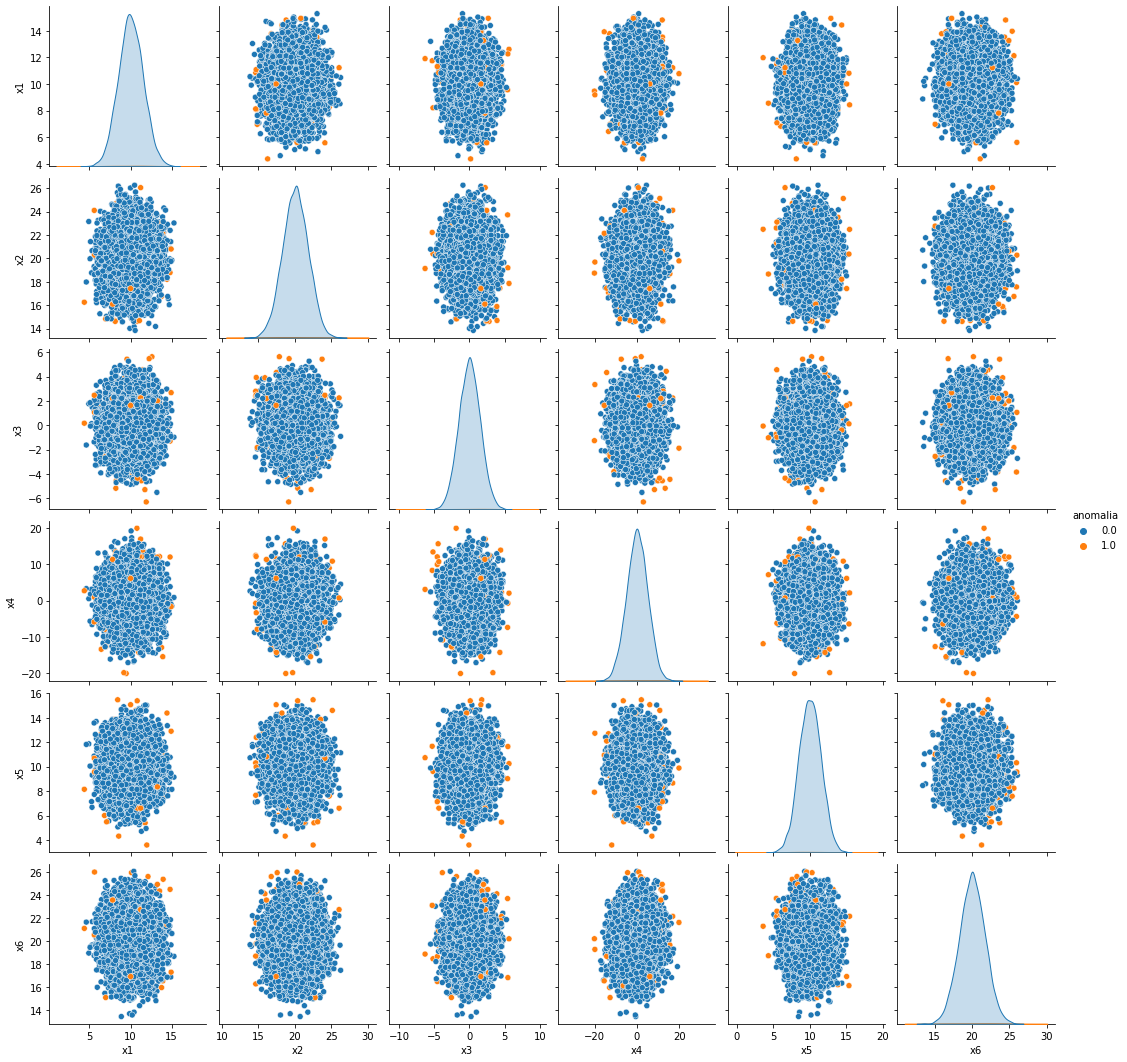

In [174]:
import seaborn as sns

sns.pairplot(df, hue="anomalia")

### Concluimos que para chegarmos proximo a quantidade de anomalias registradas na variavel df['anomalia'], teriamos que ter um epsilon proximo de 0.00000001:

In [175]:
epsilon = 0.00000001
anoma = DetectorAnomalias(epsilon=epsilon)
count = 0

for i in range(0, len(X)):
  x = X[i]
  anoma.fit(X)

  if anoma.isAnomaly(x):
    count = count + 1

print(f"Total de outliers da variavel anomalia: {df.anomalia.loc[df.anomalia == 1].count()}")
print(f"% de outliers da variavel anomalia: {df.anomalia.loc[df.anomalia == 1].count() / df.shape[0] * 100}")
print(f"Total de outliers pelo algorimo DetectorAnomalias com epsilon = {epsilon}: {count}")
print(f"% de outliers pelo algorimo DetectorAnomalias com epsilon = {epsilon}: {count / df.shape[0] * 100}")

Total de outliers da variavel anomalia: 54
% de outliers da variavel anomalia: 0.5346534653465347
Total de outliers pelo algorimo DetectorAnomalias com epsilon = 1e-08: 62
% de outliers pelo algorimo DetectorAnomalias com epsilon = 1e-08: 0.6138613861386139


### Vamos loopar o epsilon em passos proximos ao "epsilon ideal" encontrado acima e comparar os resultados:

In [176]:
epsilon_range = np.arange(epsilon * 0.7, epsilon * 1.3, epsilon * 0.1)

print("Range de epsilons:")
for i in epsilon_range:
  print(i)

colunas = ['epsilon','prob', 'anomaly']
results = pd.DataFrame(columns=colunas)

print("_" * 100)

for j in epsilon_range:
  detecta = DetectorAnomalias(j)
  print(f"Rastreando anomalias em epsilon = {j}")
  detecta.fit(X)
  
  for i in range(0, len(X)):
    x = X[i]
    df2 = pd.DataFrame([[j, detecta.prob(x), detecta.isAnomaly(x)]], columns=colunas)
    results = results.append(df2)
  
epsilon_list = results.epsilon.unique()

Range de epsilons:
7e-09
8e-09
9.000000000000001e-09
1.0000000000000002e-08
1.1000000000000003e-08
1.2000000000000003e-08
____________________________________________________________________________________________________
Rastreando anomalias em epsilon = 7e-09
Rastreando anomalias em epsilon = 8e-09
Rastreando anomalias em epsilon = 9.000000000000001e-09
Rastreando anomalias em epsilon = 1.0000000000000002e-08
Rastreando anomalias em epsilon = 1.1000000000000003e-08
Rastreando anomalias em epsilon = 1.2000000000000003e-08


### Concluimos que se o epsilon ideal para equiparar os resultados com o df['anomalia'], seria proximo de 8e-09. Ou, dependendo do contexto do problema a ser solucionado, poderiamos utilizar epsilons maiores ou menores:

In [177]:
print(f"Shape do dataset: {X.shape}")
soma_original = (df.anomalia.loc[df['anomalia'] == 1].sum() / df.shape[0]).round(2)
print(f"Representacao de anomalias registradas no dataset original: {soma_original}")
print("_" * 50)
for i in range(0, len(epsilon_list)):
  print(f"Resultados com epislon = {epsilon_list[i]}:")
  soma = results.loc[((results['anomaly'] == 1) & (results['epsilon'] == epsilon_list[i]))].sum().sum().round(0)
  print(f"Total de anomalias: {soma}")
  print(f"Representacao % no total de dados com epsilon = {epsilon_list[i]}:")
  print((soma / len(X) * 100).round(2))
  print("_" * 100)

Shape do dataset: (10100, 6)
Representacao de anomalias registradas no dataset original: 0.01
__________________________________________________
Resultados com epislon = 7e-09:
Total de anomalias: 49.0
Representacao % no total de dados com epsilon = 7e-09:
0.49
____________________________________________________________________________________________________
Resultados com epislon = 8e-09:
Total de anomalias: 54.0
Representacao % no total de dados com epsilon = 8e-09:
0.53
____________________________________________________________________________________________________
Resultados com epislon = 9.000000000000001e-09:
Total de anomalias: 56.0
Representacao % no total de dados com epsilon = 9.000000000000001e-09:
0.55
____________________________________________________________________________________________________
Resultados com epislon = 1.0000000000000002e-08:
Total de anomalias: 62.0
Representacao % no total de dados com epsilon = 1.0000000000000002e-08:
0.61
__________________

In [178]:
results.loc[((results['anomaly'] == 1) & (results['epsilon'] == epsilon_list[0]))]

epsilon          prob anomaly
0  7.000000e-09  4.890683e-10       1
0  7.000000e-09  7.768505e-10       1
0  7.000000e-09  2.032235e-09       1
0  7.000000e-09  1.895656e-09       1
0  7.000000e-09  4.488448e-09       1
0  7.000000e-09  6.440161e-11       1
0  7.000000e-09  1.257155e-09       1
0  7.000000e-09  4.361644e-09       1
0  7.000000e-09  6.992199e-09       1
0  7.000000e-09  2.742198e-09       1
0  7.000000e-09  3.311846e-10       1
0  7.000000e-09  3.677998e-10       1
0  7.000000e-09  1.231942e-09       1
0  7.000000e-09  2.624980e-09       1
0  7.000000e-09  2.774153e-09       1
0  7.000000e-09  2.143021e-09       1
0  7.000000e-09  4.567021e-09       1
0  7.000000e-09  3.407569e-09       1
0  7.000000e-09  5.719884e-09       1
0  7.000000e-09  1.838292e-09       1
0  7.000000e-09  4.894651e-09       1
0  7.000000e-09  4.281482e-09       1
0  7.000000e-09  5.853512e-09       1
0  7.000000e-09  5.146671e-09       1
0  7.000000e-09  5.741676e-10       1
0  7.000000e-09  1.681631e-09       1
0  7.000000e-09  6.427829e-09       1
0  7.000000e-09  3.705722e-10       1
0  7.000000e-09  1.212128e-09       1
0  7.000000e-09  2.348560e-09       1
0  7.000000e-09  3.385938e-09       1
0  7.000000e-09  5.031388e-10       1
0  7.000000e-09  1.984223e-09       1
0  7.000000e-09  3.650838e-09       1
0  7.000000e-09  6.088426e-09       1
0  7.000000e-09  6.439918e-10       1
0  7.000000e-09  3.835627e-09       1
0  7.000000e-09  5.213001e-09       1
0  7.000000e-09  6.346561e-09       1
0  7.000000e-09  3.851176e-10       1
0  7.000000e-09  3.422166e-09       1
0  7.000000e-09  3.115817e-09       1
0  7.000000e-09  6.437821e-09       1
0  7.000000e-09  6.527525e-09       1
0  7.000000e-09  3.815236e-09       1
0  7.000000e-09  1.661129e-09       1
0  7.000000e-09  6.119735e-09       1
0  7.000000e-09  1.142691e-09       1
0  7.000000e-09  4.863364e-09       1

In [179]:
results.to_csv("results.csv", encoding='utf-8', header=True, index=False)

## Exercicio 2:


Aborde o problema num contexto de aprendizado supervisionado, ou seja, treine modelos de classificação binária com o objetivo de detectar anomalias.

Compare os resultados entre as metodologias.

### Trabalharemos com regressao logistica:

### Splitando os dados e comparando treino / teste:

In [180]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='anomalia')
y = df.anomalia

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=7)

print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

# Verificando a % de anomalias em cada particao:

print(f"ytrain: {ytrain.where(ytrain == 1).dropna().count()}")
print(f"ytest: {ytest.where(ytest == 1).dropna().count()}")
print(f"Total de anomalias em X: {ytrain.where(ytrain == 1).dropna().count() + ytest.where(ytest == 1).dropna().count()}")
print(f"Total de intancias em X: {X.shape[0]}")

(7575, 6)
(2525, 6)
(7575,)
(2525,)
ytrain: 39
ytest: 15
Total de anomalias em X: 54
Total de intancias em X: 10100


### Vamos customizar a class_weight para termos um custo favoravel:

In [247]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(Xtrain, ytrain)


print("tuned hpyerparameters :(best parameters) ",gridsearch.best_params_)
print("accuracy :",gridsearch.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed:   32.0s


tuned hpyerparameters :(best parameters)  {'class_weight': {0: 0.014924623115577889, 1: 0.9850753768844221}}
accuracy : 0.10158730158730159


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.1s finished


### Vemos que o algoritmo tem facilidade em encontrar instancias nao anomalas, porem mais dificuldade em probabilizar instancias anomalas:

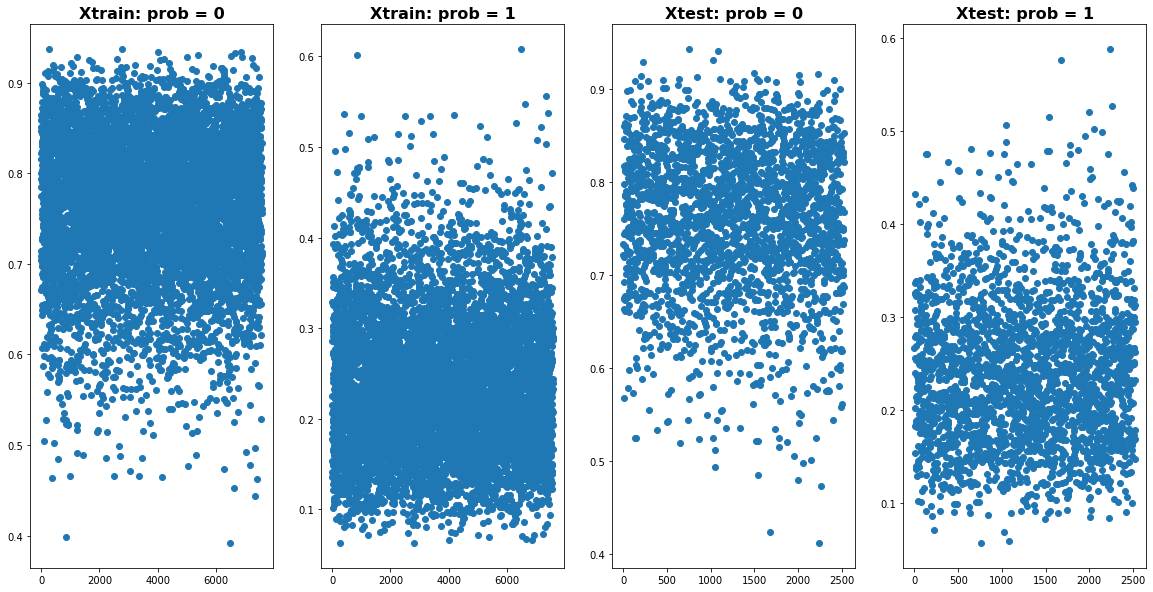

In [248]:
gridsearch.best_estimator_.predict_proba(Xtest)

plt.figure(figsize=[20, 10])
plt.subplot(1,4,1)
plt.title("Xtrain: prob = 0", fontsize = 16, fontweight = 'bold')
plt.scatter(np.arange(0, len(gridsearch.predict_proba(Xtrain)[:,0])), gridsearch.predict_proba(Xtrain)[:,0])

plt.subplot(1,4,2)
plt.title("Xtrain: prob = 1", fontsize = 16, fontweight = 'bold')
plt.scatter(np.arange(0, len(gridsearch.predict_proba(Xtrain)[:,0])), gridsearch.predict_proba(Xtrain)[:,1])

plt.subplot(1,4,3)
plt.title("Xtest: prob = 0", fontsize = 16, fontweight = 'bold')
plt.scatter(np.arange(0, len(gridsearch.predict_proba(Xtest)[:,0])), gridsearch.predict_proba(Xtest)[:,0])

plt.subplot(1,4,4)
plt.title("Xtest: prob = 1", fontsize = 16, fontweight = 'bold')
plt.scatter(np.arange(0, len(gridsearch.predict_proba(Xtest)[:,0])), gridsearch.predict_proba(Xtest)[:,1])

plt.show()

In [249]:
Xtrain_proba = Xtrain.copy()
Xtrain_proba['proba_0'] = gridsearch.predict_proba(Xtrain)[:,0]
Xtrain_proba['proba_1'] = gridsearch.predict_proba(Xtrain)[:,1]

In [250]:
Xtest_proba = Xtest.copy()
Xtest_proba['proba_0'] = gridsearch.predict_proba(Xtest)[:,0]
Xtest_proba['proba_1'] = gridsearch.predict_proba(Xtest)[:,1]

In [251]:
import warnings
warnings.filterwarnings('ignore')

#### Proba em dados de treino, chances de ser anomalia (proba = 1):

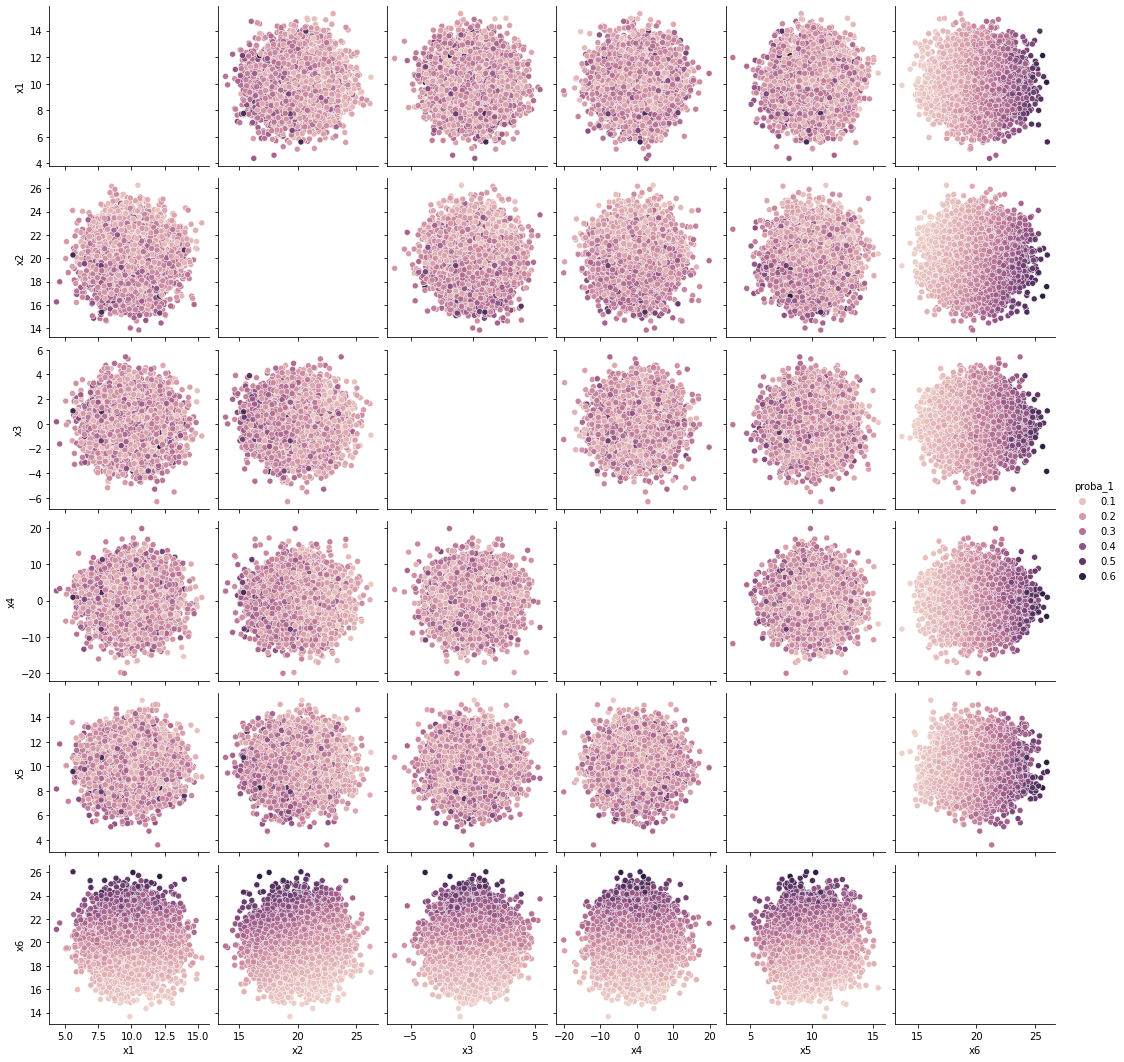

In [252]:
sns.pairplot(Xtrain_proba.drop(columns="proba_0"), hue = "proba_1")

#### Proba em dados de teste, chances de ser anomalia (proba = 1):

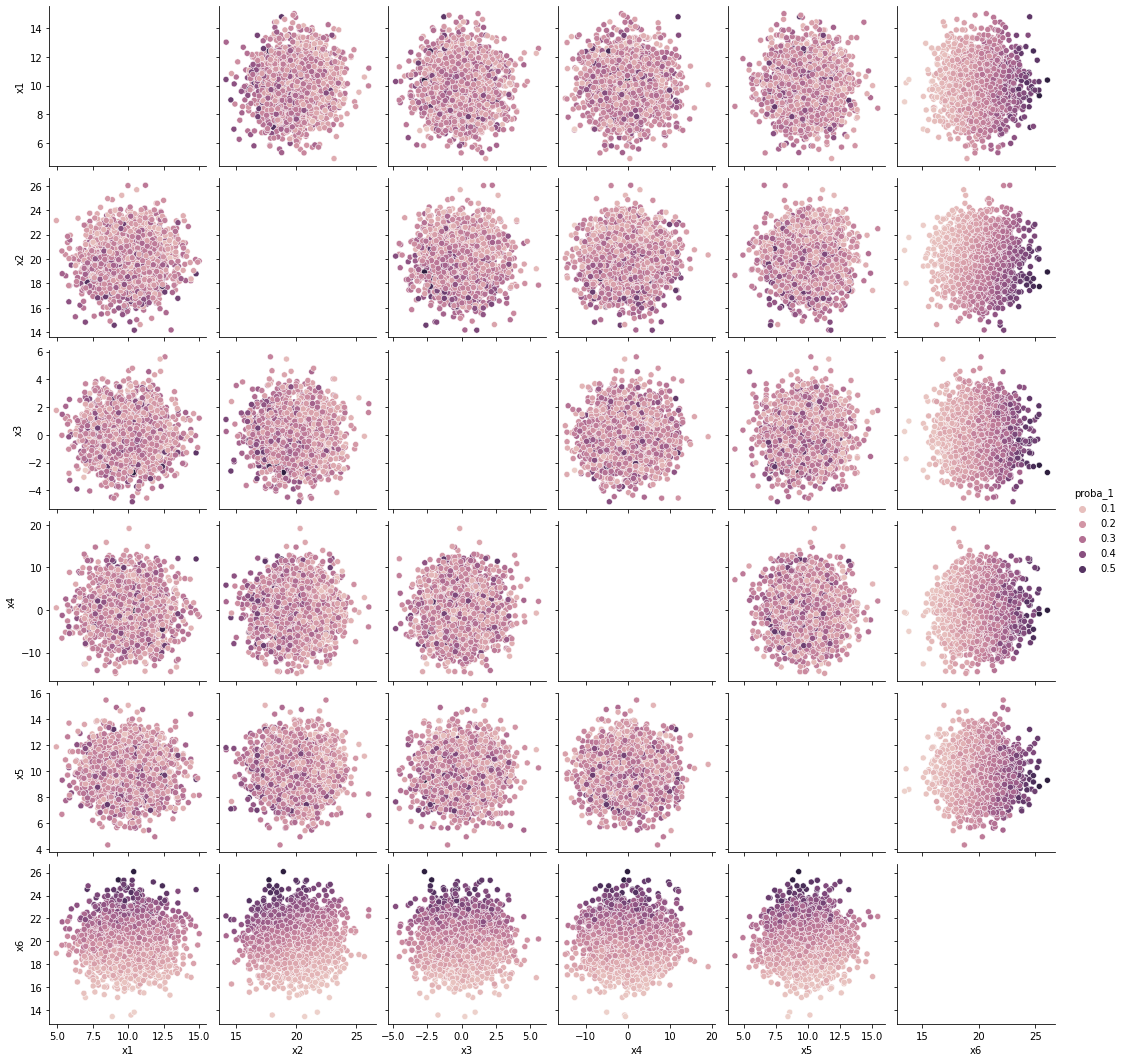

In [253]:
sns.pairplot(Xtest_proba.drop(columns="proba_0"), hue = "proba_1")

### Comparando a progressao, tambem podemos ver que ha harmonia entre os dados de treino e teste, apesar da dificuldade do algorimo em afirmar probas maiores que 0.4:

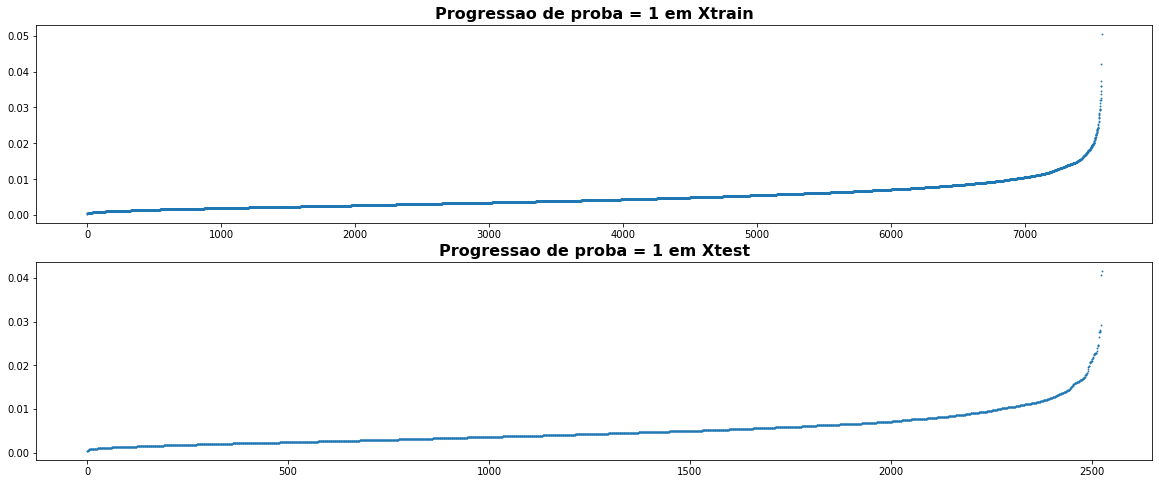

In [207]:
plt.figure(figsize=[20, 8])
plt.subplot(2,1,1)
plt.title("Progressao de proba = 1 em Xtrain", fontsize = 16, fontweight = 'bold')
plt.scatter(np.arange(0, len(Xtrain_proba)), np.sort(Xtrain_proba.proba_1), s=0.7)

plt.subplot(2,1,2)
plt.title("Progressao de proba = 1 em Xtest", fontsize = 16, fontweight = 'bold')
plt.scatter(np.arange(0, len(Xtest_proba)), np.sort(Xtest_proba.proba_1), s=0.7)

plt.show()

### Predicoes finais em Xtest:

In [268]:
# Treinando nos dados de teste:
Xtest_proba['anomalies'] = gridsearch.best_estimator_.predict(Xtest)

#Comparando % de anomalias previamente registradas x anomalias em classificacao binaria:
print("anomalias previamente registradas nos dados de teste:", ytest.sum())
print("anomalias previamente registradas nos dados de teste:", Xtest_proba['anomalies'].sum())
print("% de anomalias previamente registradas nos dados de teste:", (ytest.sum()) / len(Xtest))
print("% de anomalias previamente registradas nos dados de teste:", Xtest_proba['anomalies'].sum() / len(Xtest))

anomalias previamente registradas nos dados de teste: 15.0
anomalias previamente registradas nos dados de teste: 7.0
% de anomalias previamente registradas nos dados de teste: 0.005940594059405941
% de anomalias previamente registradas nos dados de teste: 0.002772277227722772


### Visao geral de anomalias detectadas nos dados de teste:

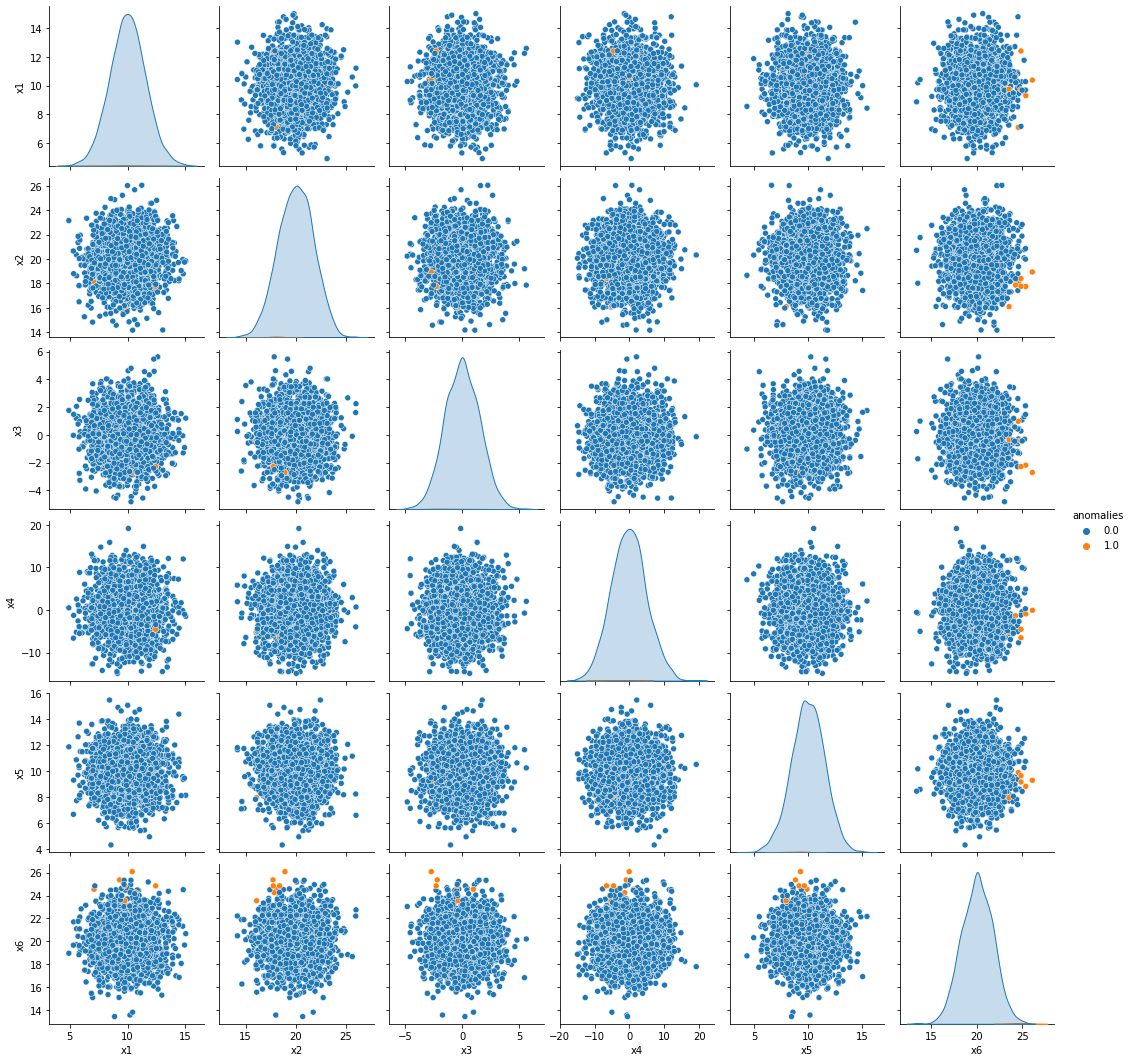

In [269]:
ignore_columns = ['proba_0', 'proba_1']

sns.pairplot(Xtest_proba.drop(columns= ignore_columns), hue = "anomalies")

In [257]:
plt.title("Progressao de proba = 1 em Xtest", fontsize = 16, fontweight = 'bold')
plt.scatter(np.arange(0, len(Xtest_proba)), np.sort(Xtest_proba.proba_1), s=0.7)

plt.show()

x1         x2        x3  ...   proba_0   proba_1  anomalies
3310  12.270614  18.174374  0.814340  ...  0.780451  0.219549        0.0
3090  10.394986  21.456028  0.760846  ...  0.832472  0.167528        0.0
6150   8.793061  20.042346  1.590654  ...  0.762046  0.237954        0.0
5718  10.460391  21.261394 -1.657885  ...  0.797610  0.202390        0.0

[4 rows x 9 columns]

In [230]:
ns.pairplot(Xtrain_proba.drop(columns="proba_0"), hue = "proba_1")

(2833.0, (7575, 6))

## Conclusao:

### Vimos que precisamos de um epsilon extremamente baixo para chegarmos a resultados parecidos com a anomalia originalmente registrada no dataset. E utilizando classificacao binaria, constatamos que se faz necessario um class_weights personalizado.

Dependendo do contexto, podemos dizer que a classificacao binaria por logistic regression demonstra apontar as anomalias com mais rigor, ou 